In [10]:
import os
import polars as pl
import sys
import time
import torch
import numpy as np

sys.path.append(os.path.abspath("../.."))
torch.cuda.manual_seed(42)
np.random.seed(42)
from sprctrum.models.sr_cnn import SR_CNN

In [11]:
# get all kpi_id from ../../datasets/KPI/train/*.csv
kpi_files = os.listdir("../../datasets/KPI/train/")
kpi_ids = [f.split(".csv")[0] for f in kpi_files]
print(sorted(kpi_ids))

['0efb375b-b902-3661-ab23-9a0bb799f4e3', '301c70d8-1630-35ac-8f96-bc1b6f4359ea', 'c02607e8-7399-3dde-9d28-8a8da5e5d251', 'e0747cad-8dc8-38a9-a9ab-855b61f5551d']


In [12]:
kpi_id = sorted(kpi_ids)[1]
print(f"Selected kpi_id: {kpi_id}")
data_path = f"../../datasets/KPI/train/{kpi_id}.csv"
data = pl.read_csv(data_path)
data.head()

Selected kpi_id: 301c70d8-1630-35ac-8f96-bc1b6f4359ea


timestamp,value,label
i64,f64,i64
1474646400,0.254939,0
1474646700,0.247444,0
1474647000,0.238677,0
1474647300,0.240315,0
1474647600,0.218478,0


In [13]:
# train the model
start = time.time()
model = SR_CNN(epochs=120)
model.fit(data["value"], data["label"])
end = time.time()
print(f"Training completed in {end - start} seconds.")

Epoch 120/120: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s, loss=1.17]


Training time: 34.05 seconds
Final epoch average loss: 1.166933
Training completed in 34.27690553665161 seconds.


In [14]:
start = time.time()
test_data = pl.read_csv(f"../../datasets/KPI/test/{kpi_id}.csv")
result = model.predict(test_data["value"])
end = time.time()
print(f"Prediction completed in {end - start} seconds.")
result

Prediction completed in 86.56245183944702 seconds.


""
f64
0.0
0.0
0.0
0.0
0.0
…
0.427275
0.44742
0.454158


In [15]:
# check result > 0.95 number
print("Evaluating results...")
print(f"Total test samples: {len(result)}")
print(result.max())
anomaly_count = (result > 0.4).sum()
print(f"Number of anomalies detected (score > 0.95): {anomaly_count}")

true_labels = test_data["label"].to_numpy()
predicted_labels = (result > 0.4).to_numpy().astype(int)
correct_count = (true_labels == predicted_labels).sum()
accuracy = correct_count / len(true_labels)
precision = correct_count / (anomaly_count if anomaly_count > 0 else 1)
recall = correct_count / (true_labels.sum() if true_labels.sum() > 0 else 1)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Done.")

Evaluating results...
Total test samples: 8784
0.49963346123695374
Number of anomalies detected (score > 0.95): 7087
Precision: 0.2660
Recall: 9.1505
Accuracy: 0.2146
Done.


In [19]:
# Experiment: Compare original sequence vs Spectral Residual processed sequence
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sprctrum.models.sr_cnn.spectral_residual import spectral_residual, extend_series

# Select a KPI ID for visualization (choose one with anomalies)
selected_kpi = "301c70d8-1630-35ac-8f96-bc1b6f4359ea"  # This KPI has high anomaly rate
print(f"Selected KPI for visualization: {selected_kpi}")

# Load test data for the selected KPI
test_data_path = f"../../datasets/KPI/test/{selected_kpi}.csv"
test_data = pl.read_csv(test_data_path)

print(f"Test data shape: {test_data.shape}")
print(f"Anomaly points: {test_data['label'].sum()}")
print(f"Anomaly rate: {test_data['label'].sum() / len(test_data) * 100:.2f}%")

# Select a subset for visualization (e.g., first 2000 points)
subset_size = 2000
subset_data = test_data
values = subset_data["value"].to_numpy()
labels = subset_data["label"].to_numpy()
timestamps = pd.to_datetime(subset_data["timestamp"], unit="s")

# Apply Spectral Residual transformation
print("Applying Spectral Residual transformation...")
extended_values = extend_series(pl.Series(values), extend_num=5, look_ahead=5)
sr_values = spectral_residual(extended_values)
# Trim back to original length
sr_values = sr_values[: len(values)]

print(f"Original values range: [{values.min():.4f}, {values.max():.4f}]")
print(f"SR values range: [{sr_values.min():.4f}, {sr_values.max():.4f}]")

Selected KPI for visualization: 301c70d8-1630-35ac-8f96-bc1b6f4359ea
Test data shape: (8784, 3)
Anomaly points: 206
Anomaly rate: 2.35%
Applying Spectral Residual transformation...
Original values range: [0.0000, 0.4249]
SR values range: [0.0001, 0.2087]


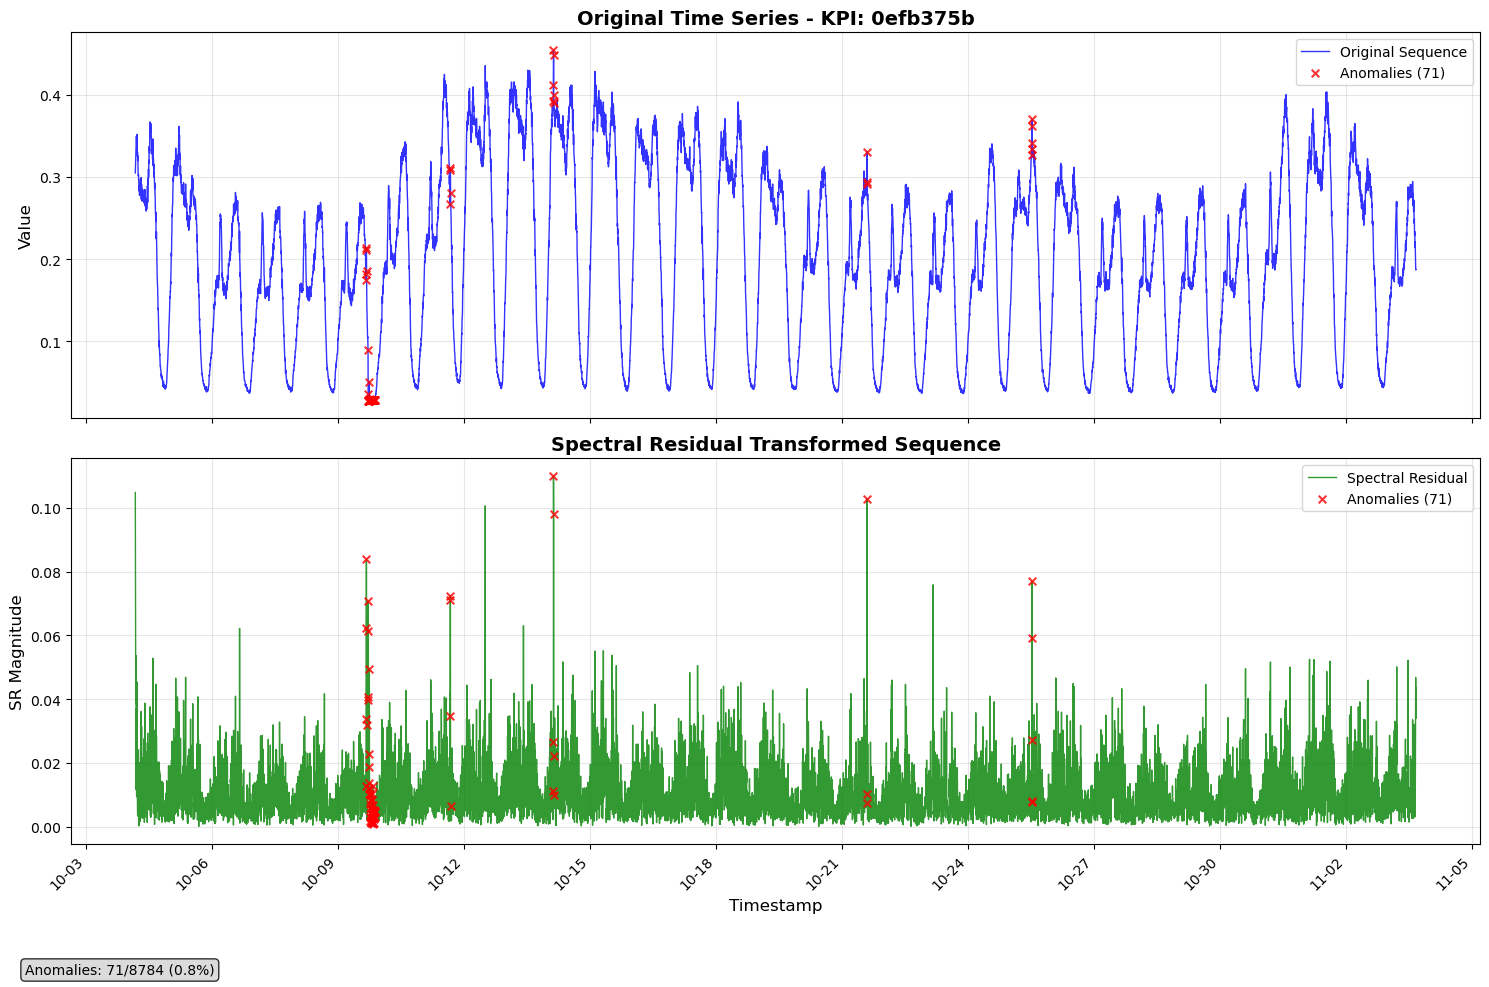

Visualization completed!
Time range: 2016-10-04 04:00:00 to 2016-11-03 15:55:00
Duration: 731.9 hours


In [17]:
# Create visualization: Original vs Spectral Residual sequences with anomaly markers
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot 1: Original sequence
ax1.plot(timestamps, values, "b-", linewidth=1, alpha=0.8, label="Original Sequence")

# Mark anomalies in original sequence
anomaly_indices = np.where(labels == 1)[0]
if len(anomaly_indices) > 0:
    ax1.scatter(
        timestamps[anomaly_indices],
        values[anomaly_indices],
        color="red",
        s=30,
        marker="x",
        alpha=0.8,
        label=f"Anomalies ({len(anomaly_indices)})",
        zorder=5,
    )

ax1.set_title(
    f"Original Time Series - KPI: {selected_kpi[:8]}", fontsize=14, fontweight="bold"
)
ax1.set_ylabel("Value", fontsize=12)
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Plot 2: Spectral Residual processed sequence
ax2.plot(timestamps, sr_values, "g-", linewidth=1, alpha=0.8, label="Spectral Residual")

# Mark anomalies in SR sequence
if len(anomaly_indices) > 0:
    ax2.scatter(
        timestamps[anomaly_indices],
        sr_values[anomaly_indices],
        color="red",
        s=30,
        marker="x",
        alpha=0.8,
        label=f"Anomalies ({len(anomaly_indices)})",
        zorder=5,
    )

ax2.set_title("Spectral Residual Transformed Sequence", fontsize=14, fontweight="bold")
ax2.set_xlabel("Timestamp", fontsize=12)
ax2.set_ylabel("SR Magnitude", fontsize=12)
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

# Format x-axis - 调整时间戳密度
import matplotlib.dates as mdates

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))  # 只显示月-日
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # 每3天显示一次
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

# Add statistics text
stats_text = f"""Anomalies: {len(anomaly_indices)}/{len(values)} ({len(anomaly_indices)/len(values)*100:.1f}%)"""

fig.text(
    0.02,
    0.02,
    stats_text,
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

print("Visualization completed!")
print(f"Time range: {timestamps.min()} to {timestamps.max()}")
print(
    f"Duration: {(timestamps.max() - timestamps.min()).total_seconds() / 3600:.1f} hours"
)

Training SR-CNN model on selected KPI...


Epoch 120/120: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s, loss=0.969]



Training time: 34.74 seconds
Final epoch average loss: 0.968743
Getting predictions...


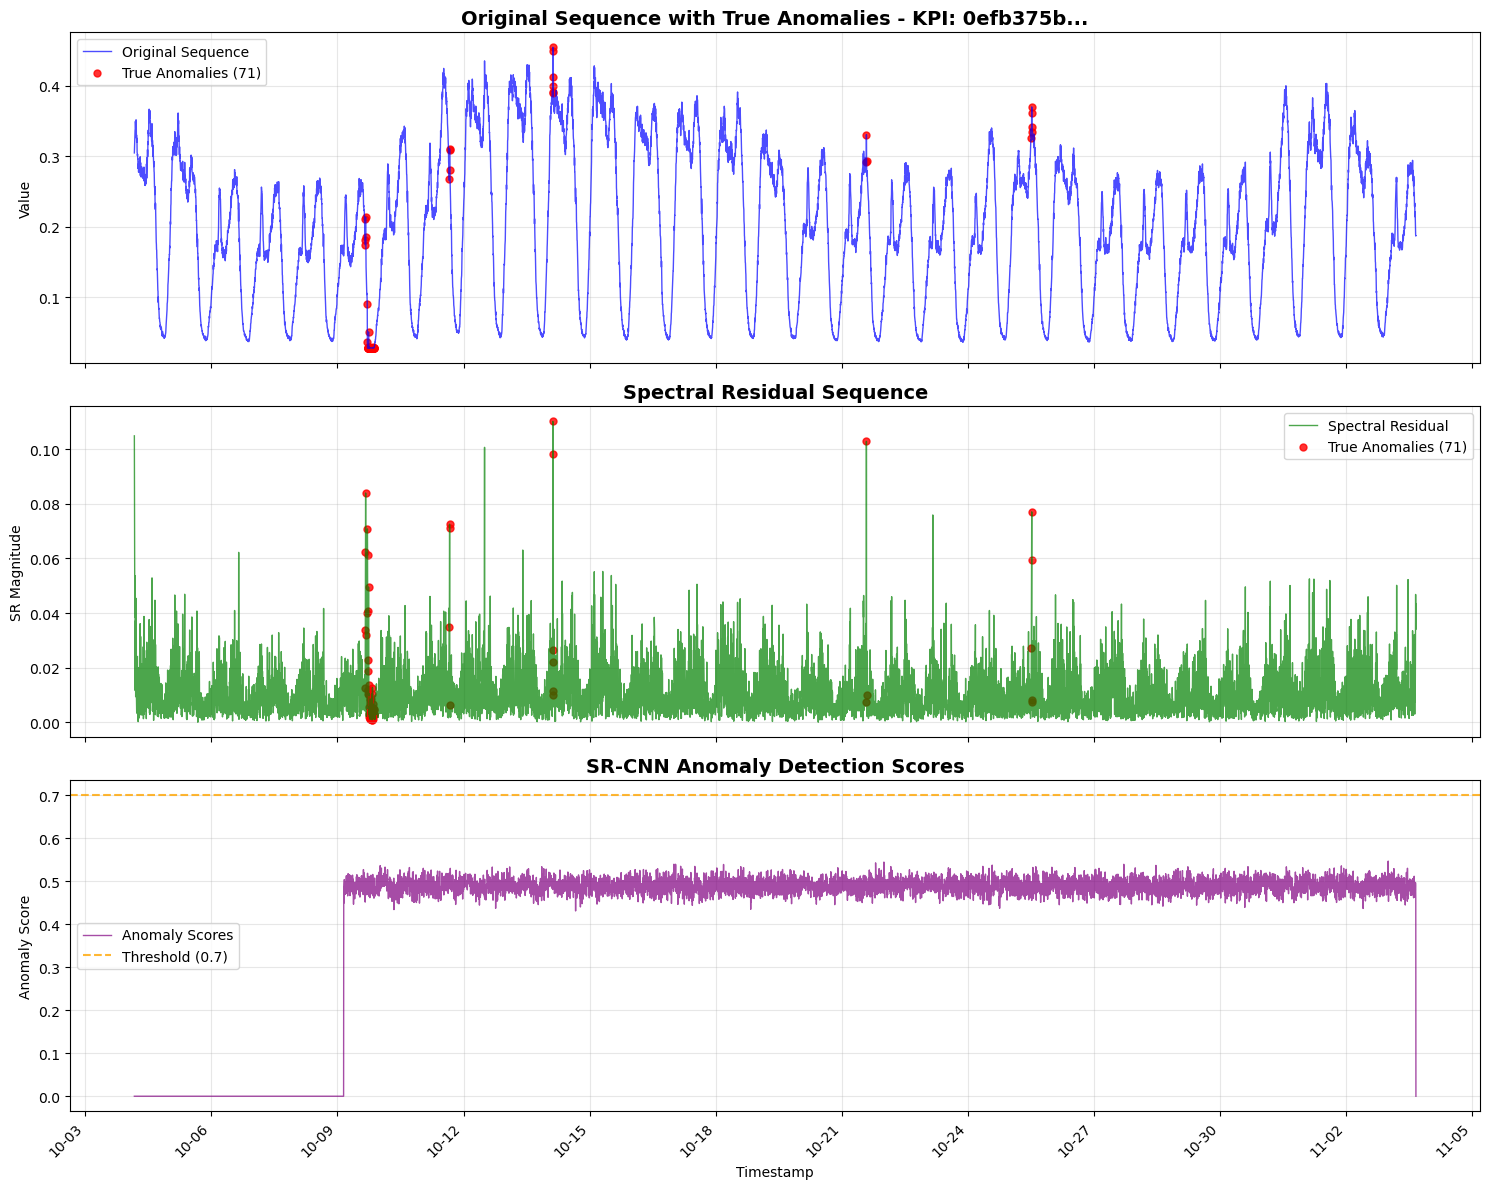


Performance Metrics (threshold=0.7):
True Positives: 0
False Positives: 0
False Negatives: 71
True Negatives: 8713
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


In [18]:
# Additional analysis: Anomaly detection performance visualization
# Train the model on the selected KPI and visualize predictions

print("Training SR-CNN model on selected KPI...")
train_data_path = f"../../datasets/KPI/train/{selected_kpi}.csv"
train_data = pl.read_csv(train_data_path)

# Train model
model_analysis = SR_CNN(epochs=120)  # Reduced epochs for faster demo
model_analysis.fit(train_data["value"], train_data["label"])

# Get predictions on test subset
print("Getting predictions...")
predictions = model_analysis.predict(subset_data["value"])
pred_scores = predictions.to_numpy()

# Create anomaly detection visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Plot 1: Original sequence with true anomalies
ax1.plot(timestamps, values, "b-", linewidth=1, alpha=0.7, label="Original Sequence")
if len(anomaly_indices) > 0:
    ax1.scatter(
        timestamps[anomaly_indices],
        values[anomaly_indices],
        color="red",
        s=25,
        marker="o",
        alpha=0.8,
        label=f"True Anomalies ({len(anomaly_indices)})",
    )
ax1.set_title(
    f"Original Sequence with True Anomalies - KPI: {selected_kpi[:8]}...",
    fontsize=14,
    fontweight="bold",
)
ax1.set_ylabel("Value")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Spectral Residual sequence
ax2.plot(timestamps, sr_values, "g-", linewidth=1, alpha=0.7, label="Spectral Residual")
if len(anomaly_indices) > 0:
    ax2.scatter(
        timestamps[anomaly_indices],
        sr_values[anomaly_indices],
        color="red",
        s=25,
        marker="o",
        alpha=0.8,
        label=f"True Anomalies ({len(anomaly_indices)})",
    )
ax2.set_title("Spectral Residual Sequence", fontsize=14, fontweight="bold")
ax2.set_ylabel("SR Magnitude")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Anomaly scores from SR-CNN
ax3.plot(
    timestamps, pred_scores, "purple", linewidth=1, alpha=0.7, label="Anomaly Scores"
)
# Add threshold line
threshold = 0.7
ax3.axhline(
    y=threshold,
    color="orange",
    linestyle="--",
    alpha=0.8,
    label=f"Threshold ({threshold})",
)
# Mark predicted anomalies
pred_anomalies = pred_scores > threshold
if pred_anomalies.sum() > 0:
    ax3.scatter(
        timestamps[pred_anomalies],
        pred_scores[pred_anomalies],
        color="red",
        s=25,
        marker="^",
        alpha=0.8,
        label=f"Predicted Anomalies ({pred_anomalies.sum()})",
    )
ax3.set_title("SR-CNN Anomaly Detection Scores", fontsize=14, fontweight="bold")
ax3.set_xlabel("Timestamp")
ax3.set_ylabel("Anomaly Score")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Format x-axis - 调整时间戳密度
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))  # 只显示月-日
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # 每3天显示一次
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Performance metrics
true_positives = ((labels == 1) & (pred_scores > threshold)).sum()
false_positives = ((labels == 0) & (pred_scores > threshold)).sum()
false_negatives = ((labels == 1) & (pred_scores <= threshold)).sum()
true_negatives = ((labels == 0) & (pred_scores <= threshold)).sum()

precision = (
    true_positives / (true_positives + false_positives)
    if (true_positives + false_positives) > 0
    else 0
)
recall = (
    true_positives / (true_positives + false_negatives)
    if (true_positives + false_negatives) > 0
    else 0
)
f1_score = (
    2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
)

print(f"\nPerformance Metrics (threshold={threshold}):")
print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"True Negatives: {true_negatives}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")